Thesis: It's possible to detect delays on a project schedule for construction analisying the tasks, expected times of start, resources, task dependencies and weather conditions.

The steps to perform the analysis are:

1.   Remove tasks with non text names (1.2, 33, etc)
2.   Categorize tasks by its function
3.   Add resource type and amount to the task
4.   Add weather temp to the task
5.   Amount of dependencies per task



1.  Categorize tasks by function

# Settings

Connect to google drive to access the dataset of projects.

In [1]:
csv_folder_path = './content/drive/MyDrive/BILT'
# csv_folder_path = './CSV'
classified_tasks_filepath = './classified_tasks.csv'
training_data_path = './content/drive/MyDrive/BILT/Training_classified_tasks.csv'
Tasks_to_be_preditected ='./Baseline Zone 2 Rev/TASK.csv'


In [2]:
%pip install pandas
%pip install scikit-learn
%pip install numpy


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


We are going to use ML to create a relationship between tasks and categories and subcategories that will help up define to which group a task belong.
This list was created manually and can be edited to include more categories

In [3]:
categories_subcategories = {
    "Preliminary": ["Approval", "Submittal"],
    "Site Preparation": [
        "Clearing and Excavation",
        "Site Security Setup",
        "Utility Connections",
    ],
    "Foundation Construction": [
        "Footing Installation",
        "Foundation Concrete Pour",
        "Waterproofing and Drainage",
        "Footing",
        "BACKFILLING",
        "Foundation",
        "REBAR",
        "GROUNDING",
        "FORMWORK",
    ],
    "Structural": [
        "Steel Framing Assembly",
        "Concrete Structure Formation",
        "Wooden Frame Construction",
        "Column",
        "Columns",
        "Beam",
        "Slab",
        "Wall",
        "Beams",
        "Slabs",
        "BRICK",
        "Walls",
        "MASONRY",
        "Roof Trusses",
    ],
    "MEP Installation": [
        "HVAC System",
        "Electrical",
        "Plumbing ",
        "Fire Protection",
        "Insulation",
        "CABLES",
        "DUCTS",
        "PIPES",
        "WIRES",
        "CONDUITS",
        "PUMPS",
        "VALVES",
        "TELECOMMUNICATIONS",
        "CONTROLS",
        "AIR HANDLING UNIT",
        "CHILLERS",
        "COOLING TOWER",
        "FAN COIL UNIT",
        "FIRE ALARM",
        "FIRE SPRINKLER",
        "GENERATOR",
        "MECHNICAL EQUIPMENT",
        "PLUMBING FIXTURES",
        "LIGHTS",
        "WIRING",
        "GAS"


    ],
    "Interior Finishing": [
        "Drywall Installation",
        "Flooring",
        "Paint",
        "PAINTING",
        "Plaster",
        "Ceiling",
        "PLASTERING",
        "Fixtures and Fittings",
        "TILE",
        "CASEWORKS"
    ],
    "Exterior Finishing": [
        "Roofing",
        "Siding",
        "Windows",
        "Doors",
        "Decking",
        "Paving",
    ],
    "Shipping": ["Shipping", "Receiving", "Delivery", "Transportation", "Manufacturing"],
    "Landscaping": ["Soil Preparation", "Planting", "Hardscape Features"],
    "Other": ["Other", "Unknown", "Empty", "NAN", "   "],
}


This functions will travel through all the Task CSV files in the dataset collecting their names

In [4]:
import os
import hashlib
import pandas as pd

def get_all_data_from_csvs(start_path: str = ".",file_name:str = "TASK"):
    """Get all data from TASK.csv files in the specified directory and its subdirectories."""
    task_csv_files = find_task_csv_files(start_path,file_name)
    all_data = []
    for file_path in task_csv_files:
        # try:
        df = pd.read_csv(file_path)
        # Hash the project_name to anonymize the data
        project_name = file_path.split("/")[-2] #TODO data
        hashed_project_name = hashlib.sha1(project_name.encode()).hexdigest()
        df['file_name'] = hashed_project_name
        if 'task_name' in df.columns:
            df= df[df["task_name"] != '']
        all_data.append(df)
    df = pd.concat(all_data, ignore_index=True)
    return df


def find_task_csv_files(start_path: str, file_name:str):
    """Search for .csv files in subdirectories of the given start path."""
    for root, dirs, files in os.walk(start_path):
        for file in files:
            if file == file_name + ".csv":
                yield os.path.join(root, file)


def find_task_csv_files(start_path: str):
    """Search for TASK.csv files in subdirectories of the given start path."""
    for root, dirs, files in os.walk(start_path):
        for file in files:
            if file == "TASK.csv":
                yield root + "/"


def fix_data(df):
    """Convert date columns to datetime format."""
    date_columns = [x for x in df.columns if "date" in x]
    for col in date_columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")
    df.fillna(method="ffill", inplace=True)
    return df


def read_all_csvs(folder_path):
    files = os.listdir(folder_path)
    project_df = fix_data(pd.read_csv(folder_path + "PROJECT.csv"))
    task_df = fix_data(pd.read_csv(folder_path + "TASK.csv"))
    # task_pred_df = fix_data(pd.read_csv(folder_path + "TASKPRED.csv"))
    task_rsrc_df = pd.DataFrame(columns=["task_id", "rsrc_id"])
    rsrc_df = pd.DataFrame(columns=["rsrc_id", "rsrc_name"])
    if "TASKRSRC.csv"  in files:
        task_rsrc_df = fix_data(pd.read_csv(folder_path + "TASKRSRC.csv"))

    if "RSRC.csv"  in files:
        rsrc_df = fix_data(pd.read_csv(folder_path + "RSRC.csv"))
    # rsrc_rate_df = fix_data(pd.read_csv(folder_path + "RSRCRATE.csv"))
    if 'TASKPRED.csv' in files:
        task_pred_df = fix_data(pd.read_csv(folder_path + "TASKPRED.csv"))
        pred = task_pred_df.groupby('pred_task_id').agg(task_id_count=('task_id', 'count'))
        pred.rename(columns={'task_id_count': 'successors'}, inplace=True)
        pred = pred.rename_axis('task_id')
        task_df = pd.merge(task_df, pred, on="task_id", how="left")
    # Merging project and tasks data on a common key
    project_task_df = pd.merge(project_df, task_df, on="proj_id", how="inner")

    # Merging task resources data
    task_resources_df = pd.merge(task_rsrc_df, rsrc_df, on="rsrc_id", how="left")

    project_task_df["actual_duration"] = (
        project_task_df["act_end_date"] - project_task_df["act_start_date"]
    ).dt.days
    project_task_df["late_duration"] = (
        project_task_df["late_end_date"] - project_task_df["late_start_date"]
    ).dt.days
    project_task_df["target_duration"] = (
        project_task_df["target_end_date"] - project_task_df["target_start_date"]
    ).dt.days

    final_df = pd.merge(project_task_df, task_resources_df, on="task_id", how="left")


    return final_df


folders = find_task_csv_files(csv_folder_path)
dfs = []
for folder in folders:
    df = read_all_csvs(folder)
    dfs.append(df)
final_df = pd.concat(dfs, ignore_index=True)


c:\Users\PabloD\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\PabloD\AppData\Local\Temp\ipykernel_32552\3982789888.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
C:\Users\PabloD\AppData\Local\Temp\ipykernel_32552\3982789888.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
C:\Users\PabloD\AppData\Local\Temp\ipykernel_32552\3982789888.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
C:\Users\PabloD\AppData\Local\Temp\ipykernel_

We merge all data from Task on all projects. We use a feature extraction to classify each task

In [5]:
final_df['successors'] = final_df['successors'].fillna(0)
final_df['successors']

0         0.0
1         1.0
2         1.0
3         1.0
4         2.0
         ... 
386593    1.0
386594    1.0
386595    1.0
386596    0.0
386597    0.0
Name: successors, Length: 386598, dtype: float64

In [6]:

all_tasks_names = pd.DataFrame()
all_tasks_names["task_name"]= final_df["task_name"].dropna().unique()

We are going to do the same with the predecessors.

Group by 'task_pred_id' and count 'pred_task_id' which is the amount of dependencies a task has

## Classification
To be able to compare different tasks we need to classify them. Given this is a demo of the project using public data, the classification will be done using text vectorization and ML classification.

First we train a model with labeled data and store the model to classify the whole dataset

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline

# Load training data

df_train = pd.read_csv(training_data_path, usecols=['task_name', 'category', 'subcategory'])

# Prepare training and target datasets
X = df_train['task_name']
y = df_train[['category', 'subcategory']].astype(str).agg('_'.join, axis=1)

# Splitting the dataset for training and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a text vectorization and classification pipeline
pipeline = make_pipeline(TfidfVectorizer(), SVC(kernel='linear', probability=True))

# Training the model
pipeline.fit(X_train, y_train)

# Validating the model
predictions = pipeline.predict(X_test)
# Save the model for later use
import joblib
joblib.dump(pipeline, 'category_predictor.joblib')
print(classification_report(y_test, predictions))


                                          precision    recall  f1-score   support

                Exterior Finishing_Doors       1.00      1.00      1.00         2
              Exterior Finishing_Windows       1.00      1.00      1.00         7
      Foundation Construction_Foundation       0.00      0.00      0.00         2
              Interior Finishing_Ceiling       1.00      0.83      0.91         6
                Interior Finishing_Paint       1.00      0.86      0.92         7
              Interior Finishing_Plaster       1.00      1.00      1.00         1
             MEP Installation_Electrical       1.00      1.00      1.00         4
            MEP Installation_HVAC System       1.00      0.33      0.50         3
             MEP Installation_Insulation       0.00      0.00      0.00         1
                  MEP Installation_PUMPS       0.00      0.00      0.00         1
              MEP Installation_Plumbing        0.62      1.00      0.77         5
               

c:\Users\PabloD\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\PabloD\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\PabloD\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Once we have the model, we use it to clasiffy and store all the tasks we gather on the previous steps

In [8]:

# Load the file with tasks to classify
classified_tasks_df = all_tasks_names
assert 'task_name' in classified_tasks_df.columns, "The CSV file must contain a 'task_name' column."

# Predicting categories and subcategories for new tasks
predicted_categories = pipeline.predict(classified_tasks_df['task_name'])
classified_tasks_df['predicted'] = predicted_categories


# Splitting the predicted values back into separate category and subcategory columns
classified_tasks_df[['category', 'subcategory']] = classified_tasks_df['predicted'].str.split('_', expand=True)
classified_tasks_df.drop(columns=['predicted'], inplace=True)

# Saving the classified tasks back to the CSV
classified_tasks_df.to_csv(classified_tasks_filepath, index=False)

print("Task categorization complete. Results have been saved.")

Task categorization complete. Results have been saved.


In [9]:
def join_dataframes_on_taskname(df1, df2):
    # Ensure "task_name" is a column in both DataFrames
    if "task_name" not in df1.columns or "task_name" not in df2.columns:
        raise ValueError("Both dataframes must contain 'task_name' column")

    # Convert "task_name" in both DataFrames to uppercase for case-insensitive matching
    df1_upper = df1.copy()
    df2_upper = df2.copy()
    df1_upper['task_name'] = df1_upper['task_name'].str.upper()
    df2_upper['task_name'] = df2_upper['task_name'].str.upper()

    # Perform the join operation
    joined_df = pd.merge(df1_upper, df2_upper, on="task_name", how="inner")

    return joined_df

In [10]:
joined_df = join_dataframes_on_taskname(final_df, classified_tasks_df)

In [11]:
filtered_joined_df = joined_df[joined_df['category'] != 'Preliminary']
# filtered_joined_df = joined_df
filtered_joined_df.to_csv("joined.csv", index=False)

Complete merged dataset

In [12]:
filtered_joined_df.count()

Unnamed: 0_x_x           127143
proj_id_x                127143
fy_start_month_num       133326
chng_eff_cmp_pct_flag     98407
rsrc_self_add_flag       133326
                          ...  
guid                          0
ot_factor                     0
rsrc_type                     0
category                 133326
subcategory              133326
Length: 261, dtype: int64

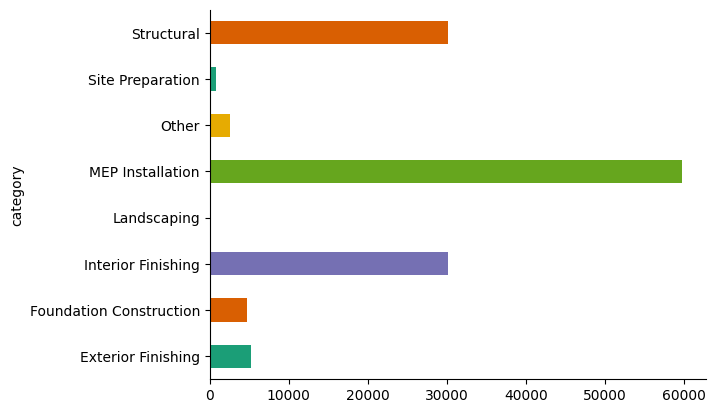

In [13]:
# @title Distribution of tasks by category and show totals

from matplotlib import pyplot as plt
import seaborn as sns
filtered_joined_df.groupby('category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [14]:
filtered_joined_df.columns

Index(['Unnamed: 0_x_x', 'proj_id_x', 'fy_start_month_num',
       'chng_eff_cmp_pct_flag', 'rsrc_self_add_flag', 'allow_complete_flag',
       'rsrc_multi_assign_flag', 'ts_rsrc_mark_act_finish_flag',
       'ts_rsrc_vw_inact_actv_flag', 'checkout_flag',
       ...
       'location_id_y', 'location_id', 'Unnamed: 0', 'role_id', 'pobs_id',
       'guid', 'ot_factor', 'rsrc_type', 'category', 'subcategory'],
      dtype='object', length=261)

C:\Users\PabloD\AppData\Local\Temp\ipykernel_32552\3111129347.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_joined_df.fillna(
C:\Users\PabloD\AppData\Local\Temp\ipykernel_32552\3111129347.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_joined_df.fillna(
C:\Users\PabloD\AppData\Local\Temp\ipykernel_32552\3111129347.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

              category  subcategory     delay  target_qty  successors  \
category      1.000000     0.291733 -0.008093    0.007710   -0.090442   
subcategory   0.291733     1.000000 -0.001979   -0.006260   -0.031699   
delay        -0.008093    -0.001979  1.000000    0.003370    0.048488   
target_qty    0.007710    -0.006260  0.003370    1.000000   -0.001553   
successors   -0.090442    -0.031699  0.048488   -0.001553    1.000000   
actual_month  0.081906     0.077024 -0.073939   -0.004533   -0.041891   
late_month    0.041998    -0.014491 -0.041953    0.004997   -0.072459   
early_month   0.047637    -0.019903 -0.022136    0.012682   -0.006523   
target_month  0.106107     0.089355 -0.332062   -0.008142   -0.094920   
actual_d     -0.033460    -0.035164 -0.426148    0.001285    0.011588   
late_d        0.130574     0.065506  0.266498   -0.009540   -0.047504   
early_d       0.129871     0.063227  0.256696   -0.008739   -0.038155   
target_d     -0.026607    -0.020761  0.878407    0.

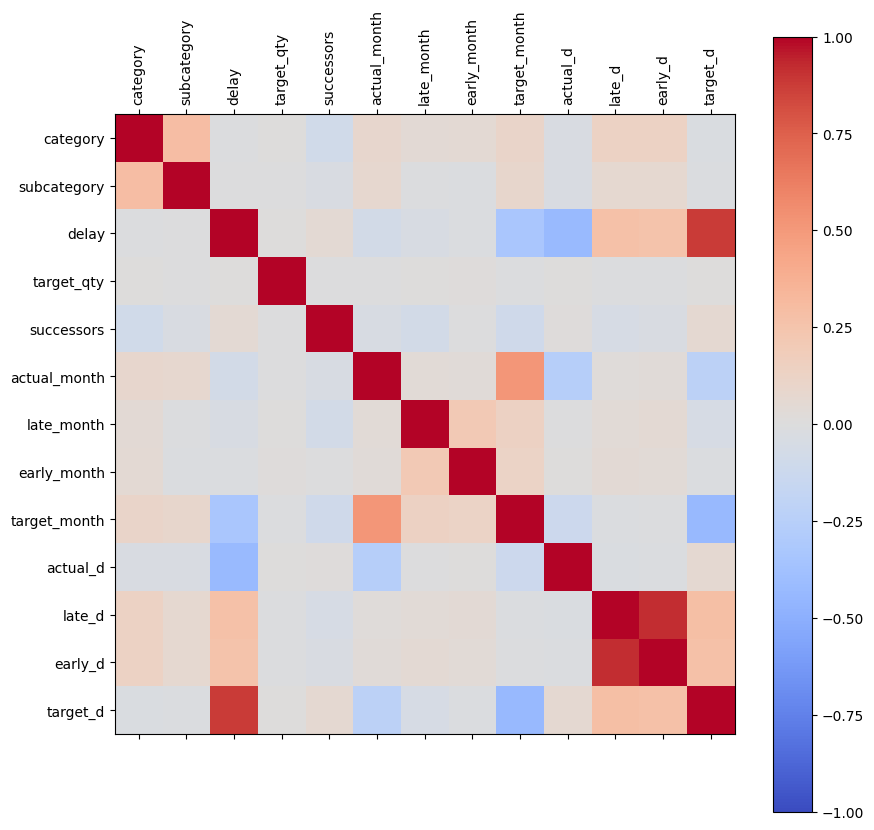

In [15]:

# read the csv file classified_tasks.csv


# fill the missing values with 0
filtered_joined_df.fillna(
    {col: 0 for col in filtered_joined_df.columns if filtered_joined_df[col].dtype != "object"}, inplace=True
)

# convert the date columns to datetime
date_columns = [x for x in filtered_joined_df.columns if "date" in x]
for col in date_columns:
    filtered_joined_df[col] = pd.to_datetime(filtered_joined_df[col], errors="coerce")
# replace all N and Y with 1 and 0 respectively
filtered_joined_df.replace({"N": 0, "Y": 1}, inplace=True)
dates = [
    ["actual_d", "act_start_date", "act_end_date"],
    ["late_d", "late_start_date", "late_end_date"],
    ["early_d", "early_start_date", "early_end_date"],
    ["target_d", "target_start_date", "target_end_date"],

]
average_date = [
    ["actual_month", "act_start_date", "act_end_date"],
    ["late_month", "late_start_date", "late_end_date"],
    ["early_month", "early_start_date", "early_end_date"],
    ["target_month", "target_start_date", "target_end_date"],
]

columns = ["category", "subcategory","delay", "target_qty", "successors" ]

#fix missing dates columns, we will use
filtered_joined_df['act_start_date'] = filtered_joined_df['act_start_date'].fillna(filtered_joined_df['target_start_date'])
for date in average_date:
    #get the average month between
    filtered_joined_df[date[0]] = (filtered_joined_df[date[1]] + (filtered_joined_df[date[2]] - filtered_joined_df[date[1]])/2  ).dt.month
    filtered_joined_df[date[0]] = filtered_joined_df[date[0]].astype("category").cat.codes
    columns.append(date[0])



for date in dates:
    #get the difference in days between the two dates
    filtered_joined_df[date[0]] = (filtered_joined_df[date[1]] - filtered_joined_df[date[2]]).dt.days
    columns.append(date[0])

filtered_joined_df["delay"] = filtered_joined_df["target_d"] - filtered_joined_df["actual_d"]

# replace strings with integers for columns category and subcategory
filtered_joined_df["category"] = filtered_joined_df["category"].astype("category").cat.codes
filtered_joined_df["subcategory"] = filtered_joined_df["subcategory"].astype("category").cat.codes
filtered_joined_df = filtered_joined_df[columns]
# draw correlation matrix with matplotlib
# use red color for negative correlation and blue color for positive correlation
# a value of 1 means perfect positive correlation
# a value of -1 means perfect negative correlation
# use column name as labels for the x and y axis
# x labeles to be vertical
# add range to graphical representation
plt.matshow(filtered_joined_df.corr(), cmap="coolwarm", vmin=-1, vmax=1)

plt.xticks(range(len(filtered_joined_df.columns)), filtered_joined_df.columns)
plt.xticks(rotation=90)
plt.yticks(range(len(filtered_joined_df.columns)), filtered_joined_df.columns)
plt.colorbar()
#make the plot bigger
plt.gcf().set_size_inches(10, 10)
# store it as a png file

plt.savefig("correlation.png")
filtered_joined_df.to_csv("processed.csv")
p = filtered_joined_df.corr()
p.to_csv("correlation.csv")
print(p)


In [16]:
filtered_joined_df[filtered_joined_df["delay"]< -20].head()

,category,subcategory,delay,target_qty,successors,actual_month,late_month,early_month,target_month,actual_d,late_d,early_d,target_d
39880,7,20,-21,0.0,1.0,4,7,7,7,0,-21,-21,-21
77123,7,2,-21,0.0,1.0,0,10,10,10,0,-21,-21,-21
118502,6,16,-25,0.0,3.0,0,0,0,0,0,-25,-25,-25
118512,7,3,-30,0.0,5.0,0,3,3,3,0,-30,-30,-30
118513,7,3,-30,0.0,5.0,0,3,3,3,0,-30,-30,-30


In [17]:
# prompt: print min max and mean of data['delay']

print(filtered_joined_df['delay'].min())
print(filtered_joined_df['delay'].max())
print(filtered_joined_df['delay'].mean())

-323
122
-0.7723099770487377


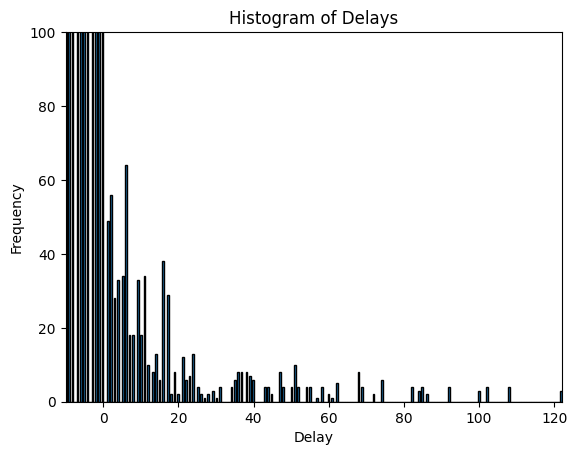

In [18]:
# prompt: Create a bar graph with bins of 25 for the values of data['delay']

# Plot histogram with 1000 bins
ax = filtered_joined_df['delay'].plot.hist(bins=1000, edgecolor='black')

# Set x-axis limit to the min and max of the data
ax.set_xlim(-10, filtered_joined_df['delay'].max())
ax.set_ylim(0, 100)
# Set y-axis limit from 0 to the max frequency in the bins


# Set the title and labels
ax.set_title('Histogram of Delays')
ax.set_xlabel('Delay')
ax.set_ylabel('Frequency')

# Show the plot
plt.show()


Approach checking the subcategories and the relation with delays

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Load your data
# Replace 'your_data.csv' with the path to your dataset
df = filtered_joined_df


# Or impute
df['delay'].fillna(df['delay'].mean(), inplace=True)
df['target_qty'].fillna(df['target_qty'].mean(), inplace=True)

# Assume 'category' is the feature and 'late_d' is the target
X = df[['category','subcategory',  "target_month", "actual_month", "successors" ]]  # Feature matrix
ydef = df['delay']  # Target variable

# Convert 'late_d' into a binary classification problem
# Here, we define a delay as any task with 'late_d' > 0
i = -1
y = (ydef >= i).astype(int)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# Preprocessing: One-hot encoding for categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['category','subcategory', "target_month", "actual_month", "successors" ]),
    ])

# Create a pipeline with preprocessing and the model
pipeline_delay = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

# Train the model
pipeline_delay.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline_delay.predict(X_test)

# Evaluate the model
print(f' Y max value: {i}')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))
print(f' ')

# Save the model for later use
import joblib
joblib.dump(pipeline_delay, 'task_delay_classifier.joblib')


C:\Users\PabloD\AppData\Local\Temp\ipykernel_32552\1313628900.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['target_qty'].fillna(df['target_qty'].mean(), inplace=True)


 Y max value: -1
Accuracy: 0.991524788119703
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       917
           1       1.00      0.99      1.00     25749

    accuracy                           0.99     26666
   macro avg       0.91      0.98      0.94     26666
weighted avg       0.99      0.99      0.99     26666

 


['task_delay_classifier.joblib']

# Processing input

Now that we have the model trained, we feed a real project into the process to detect the tipical delays

# Update a project

Once we got valid results detecting delays we realize it was half way to a valid solution. We need to update a project with this information.

We created a new model to detect and calculate delays.


Average delay error - RMSE: 9.86834021881377


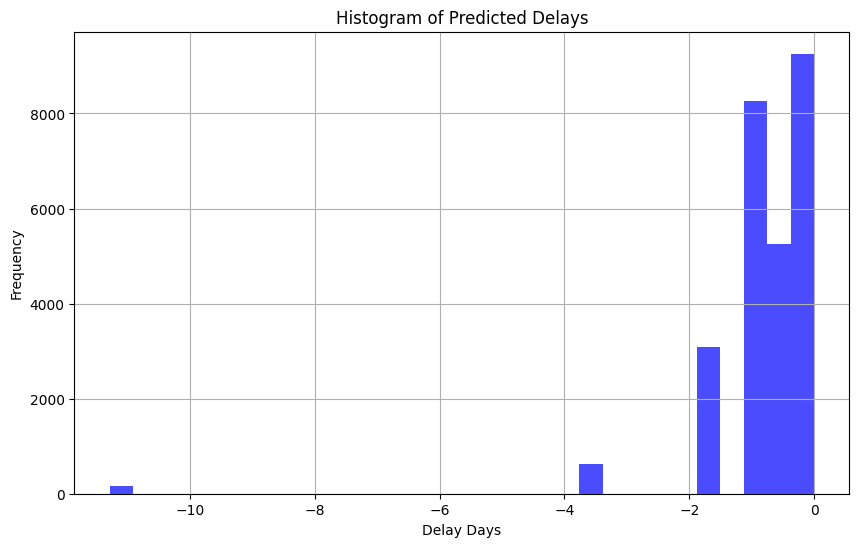

['task_delay_regressor.joblib']

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
import numpy as np

# Feature selection (Modify as per your dataset's columns)
features = ['category', 'subcategory', 'target_month', 'successors']
target = 'delay'  # This should be the actual observed delay days for each task

# Convert categorical features to category types
df['category'] = df['category'].astype('category')
df['subcategory'] = df['subcategory'].astype('category')

# Prepare the feature matrix X and target vector y
X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for numerical and categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, ['category', 'subcategory']),
    ])

# Create a regression model pipeline
regression_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model
regression_pipeline.fit(X_train, y_train)

# Save the model for later use
import joblib
joblib.dump(regression_pipeline, 'task_delay_regressor.joblib')


# Process a Project


Once we have the model trained we create a function to consume both models.

In [21]:
import pandas as pd
import numpy as np
from datetime import timedelta
import joblib

# Load models
pipeline_category = joblib.load('category_predictor.joblib')
pipeline_delay_classifier = joblib.load('task_delay_classifier.joblib')
pipeline_delay_regressor = joblib.load('task_delay_regressor.joblib')

def add_successors(task_csv_path):
    # Step 1: Load the tasks data
    task_pred_path = os.path.dirname(task_csv_path) + "TASKPRED.csv"
    task_df = pd.read_csv(task_csv_path)
    if  os.path.exists(task_pred_path):
        task_pred_df = fix_data(pd.read_csv(task_pred_path))
        pred = task_pred_df.groupby('pred_task_id').agg(task_id_count=('task_id', 'count'))
        pred.rename(columns={'task_id_count': 'successors'}, inplace=True)
        pred = pred.rename_axis('task_id')
        task_df = pd.merge(task_df, pred, on="task_id", how="left")
    else:
        task_df["successors"] = 0
    return task_df

def update_task_details(task_csv_path, tasks_df):


    # Step 1: Predict task categories and subcategories
    if 'task_name' in tasks_df.columns:
        categories_subcategories = pipeline_category.predict(tasks_df['task_name'])
        tasks_df[['category', 'subcategory']] = pd.DataFrame([x.split('_') for x in categories_subcategories], index=tasks_df.index)

    # Step 2: Preprocess data for delay prediction
    tasks_df['category'] = tasks_df['category'].astype('category').cat.codes
    tasks_df['subcategory'] = tasks_df['subcategory'].astype('category').cat.codes
    tasks_df['target_month'] = pd.to_datetime(tasks_df['target_start_date']).dt.month
    tasks_df['actual_month'] = pd.to_datetime(tasks_df['act_start_date'], errors='coerce').fillna(pd.to_datetime(tasks_df['target_start_date'])).dt.month
    tasks_df['successors'] = tasks_df['successors'].fillna(0).astype(int)

    # Prepare the feature matrix for delay prediction
    features = tasks_df[['category', 'subcategory', 'target_month', 'actual_month', 'successors']]

    # Step 3: Predict if there will be delays using the delay classification model
    delay_predictions = pipeline_delay_classifier.predict(features)

    # Step 4: Predict the number of delay days for tasks identified to likely have delays
    delay_days = pipeline_delay_regressor.predict(features[delay_predictions == 1])

    # Step 5: Update target_end_date only for delayed tasks
    delay_indices = tasks_df.index[delay_predictions == 1]  # Indices of tasks predicted to be delayed
    for idx, days in zip(delay_indices, delay_days):
        if -(days) > 1:
            # Assuming days is a variable containing the number of days to add (can be positive or negative)
            tasks_df.at[idx, 'target_end_date'] = (pd.to_datetime(tasks_df.at[idx, 'target_end_date'], errors='coerce') + timedelta(days=int(days))).strftime('%Y-%m-%d %H:%M')

    return tasks_df


tasks_df = add_successors(Tasks_to_be_preditected)

tasks_df = update_task_details(Tasks_to_be_preditected, tasks_df)
# Optionally save the updated DataFrame to a new CSV file
updated_csv_path = Tasks_to_be_preditected.replace('.csv', '_updated.csv')
print(f"Updated task details saved to {updated_csv_path}")
tasks_df.to_csv(updated_csv_path, index=False)


Updated task details saved to ./Baseline Zone 2 Rev/TASK_updated.csv


# Format
Format the dataframe to CSV compatible with MS Project


In [22]:
def convert_to_MS_Project(task_csv, pred_csv, output_filename):
    # Load the task data CSV file
    task_df = pd.read_csv(task_csv)
    # Load the predecessor data CSV
    pred_df = pd.read_csv(pred_csv)


    # Check if 'task_id' exists in both DataFrames
    if 'task_id' not in task_df.columns:
        raise ValueError("Column 'task_id' is missing in one of the files.")
    if 'task_id' not in pred_df.columns:
        raise ValueError("Column 'task_id' is missing in one of the files.")

    # Merge predecessor data into the task data based on task ID
    pred_df = pred_df[['pred_task_id', 'task_id']]

    merged_df = task_df.merge(pred_df[['task_id', 'pred_task_id']], on='task_id', how='left')

    # Rename and format columns as per MS Project requirements
    ms_project_df = merged_df[['task_id', 'task_name', 'target_start_date', 'target_end_date', 'total_float_hr_cnt', 'pred_task_id']].copy()
    # convert 'pred_task_id' to integer
    ms_project_df['pred_task_id'] = ms_project_df['pred_task_id'].fillna(0).astype(int).replace(0, '')
    # drop repeted rows
    ms_project_df = ms_project_df.drop_duplicates(subset=['task_id'], keep='first')
    #reset index
    ms_project_df.reset_index(drop=True, inplace=True)
    ms_project_df.rename(columns={
        'task_id': 'Task ID',
        'task_name': 'Task Name',
        'target_start_date': 'Start Date',
        'target_end_date': 'Finish Date',
        'total_float_hr_cnt': 'Duration (h)',
        'pred_task_id': 'Predecessor'
    }, inplace=True)

    # Format dates to match MS Project's expected format
    ms_project_df['Start Date'] = pd.to_datetime(ms_project_df['Start Date'], format='%Y-%m-%d %H:%M').dt.strftime('%m/%d/%Y')
    ms_project_df['Finish Date'] = pd.to_datetime(ms_project_df['Finish Date'], format='%Y-%m-%d %H:%M').dt.strftime('%m/%d/%Y')
    
    ms_project_df['Sorted Task ID'] = ms_project_df.index + 1
    # using the Predecessor number, get task_id and replace Predecessor with the new task_id
    for index, row in ms_project_df.iterrows():
        if row['Predecessor'] != '':
            task_id = ms_project_df.loc[ms_project_df['Task ID'] == row['Predecessor'], 'Sorted Task ID'].values
            ms_project_df.at[index, 'Predecessor'] = task_id[0]
    # Save the formatted CSV
    ms_project_df.to_csv(output_filename, index=False)
    print("CSV has been formatted and saved for MS Project.")

predecessors = Tasks_to_be_preditected.replace('TASK.csv', 'TASKPRED.csv')

baseline_project = Tasks_to_be_preditected.replace('.csv', '_baseline_processed.csv')
convert_to_MS_Project(Tasks_to_be_preditected, predecessors,baseline_project )

new_file_name = Tasks_to_be_preditected.replace('.csv', '_updated_processed.csv')
convert_to_MS_Project(updated_csv_path, predecessors, new_file_name)

CSV has been formatted and saved for MS Project.
CSV has been formatted and saved for MS Project.
